In [1]:
print("Hello Siri!")

Hello Siri!


In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

/opt/anaconda3/lib/python3.11/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


In [3]:
# Read in all the words
words = open('names.txt').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
len(words)

32033

In [5]:
# built the vocabulary of characters and mapping to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s : i + 1 for i , s in enumerate(chars)}
stoi['.'] = 0
itos = {i: s for s , i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [6]:
# Built the dataset
block_size = 3 # context length: how many characters do we take to predict the next one ?

def build_dataset(words):
    X , Y = [] , []

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape , Y.shape)
    return X , Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr , Ytr = build_dataset(words[:n1])
Xdev , Ydev = build_dataset(words[n1:n2])
Xte , Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [7]:
# MLP revised
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size , n_embd) , generator=g)
W1 = torch.randn((n_embd*block_size , n_hidden) , generator=g) * (5 / 3) / ((n_embd * block_size) ** 0.5) # * 0.2
b1 = torch.randn(n_hidden , generator=g) * 0.01
W2 = torch.randn((n_hidden , vocab_size) , generator=g) * 0.01
b2 = torch.randn(vocab_size , generator=g) * 0


bngain = torch.ones((1 , n_hidden))
bnbias= torch.zeros((1 , n_hidden))
bnmean_running = torch.zeros((1 , n_hidden))
bnstd_running = torch.ones((1 , n_hidden))


parameters = [C , W1  , W2 , b2 , bnbias , bngain]
print(sum(p.nelement() for p in parameters)) # total number of parameters
for p in parameters:
    p.requires_grad = True

12097


tensor(0.0197) tensor(0.9914)
tensor(0.0041) tensor(0.9917)


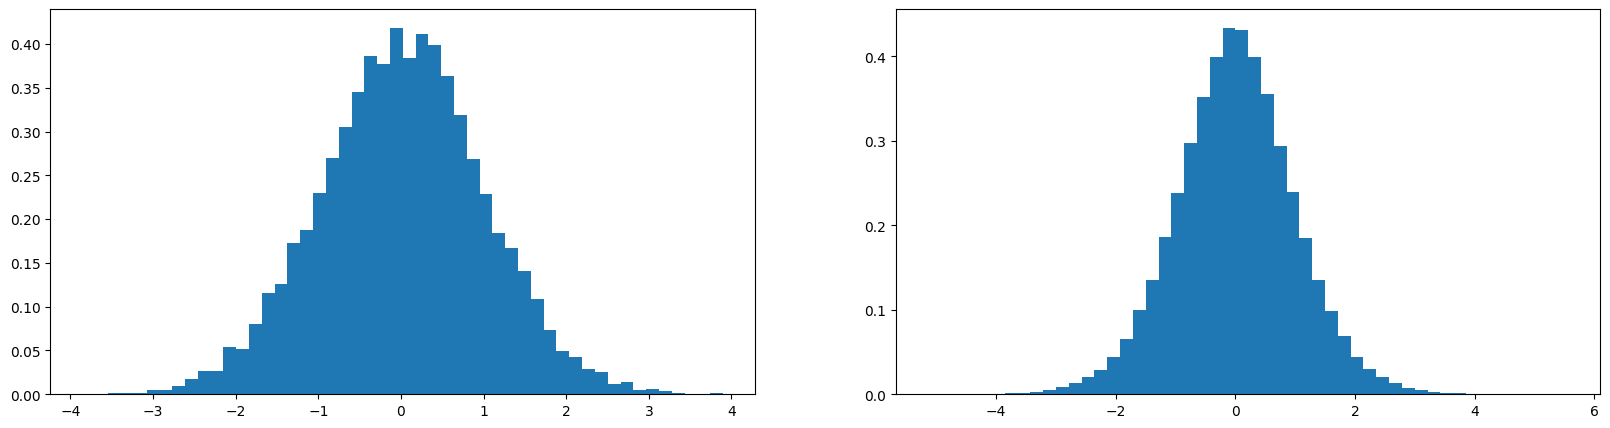

In [8]:
x = torch.randn(1000 , 10)
w = torch.randn(10 , 200) / 10**0.5
y = x @ w
print(x.mean() , x.std())
print(y.mean() , y.std())
plt.figure(figsize=(20 , 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist() , 50 , density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist() , 50 , density=True);


In [9]:
# Same optimization as last_time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0 , Xtr.shape[0] , (batch_size ,) , generator=g)
    Xb , Yb = Xtr[ix] , Ytr[ix] # batch X, Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0] , -1) # concatenate the vectors
    hpreact = embcat @ W1 # + b1 # hidden layer pre-activation
    bnmeani = hpreact.mean(0 , keepdim=True)
    bnstdi = hpreact.std(0 , keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias

    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi



    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits , Yb) # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d} / {max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    break

    

      0 /  200000: 3.3147


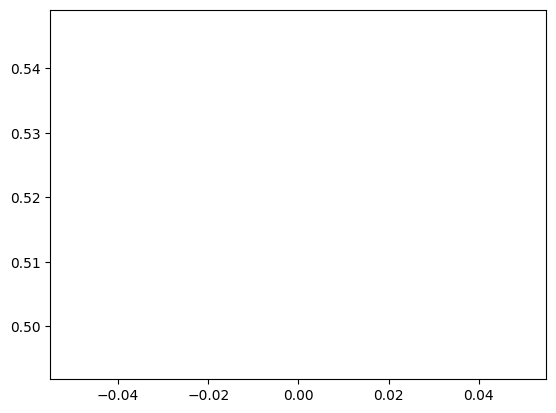

In [10]:
plt.plot(lossi)

In [11]:
# calibrate the batch norm at the end of training

with torch.no_grad():
    # pass the training set through
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0] , -1)
    hpreact = embcat @ W1 + b1

    
    # measure the mean/std over the entire training set
    bnmean = hpreact.mean(0 , keepdim=True)
    bnstd = hpreact.std(0 , keepdim=True)

In [12]:
@torch.no_grad() # this decorator disalbles gradient tracking
def split_loss(split):
    x , y = {
        'train': (Xtr , Ytr) , 
        'val': (Xdev , Ydev) , 
        'test': (Xte , Yte) , 
    }[split]
    emb = C[x] # (N , block_size , n_embed)
    embcat = emb.view(emb.shape[0] , -1) # concat inot (N , block_size*n_embed)
    hpreact = embcat @ W1 + b1
    # hpreact = bngain * (hpreact - hpreact.mean(0 , keepdim = True)) / hpreact.std(0 , keepdim=True) + bnbias
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits , y)
    print(split , loss.item())

split_loss('train')
split_loss('val')

train 3.2687273025512695
val 3.2683331966400146


In [13]:
# Sample from the model 
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...as_integer_ratio
    while True:
        # forward pass the neural net
        emb = C[torch.tensor([context])] # (1 , block_size , n_embed)
        h = torch.tanh(emb.view(1 , -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits , dim = 1)
        # sample from the distribution
        ix = torch.multinomial(probs , num_samples=1 , generator=g).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special '.' token , break
        if ix == 0:
            break
    print(''.join(itos[i] for i in out)) # decode and print the generated word

cbrpzhxqtbfhqvkfkwmrpxqthtykhkcaqskejrzhnbnfqpwsyhc.
vgqhiu.
rrmuqptcmziivdyxlhggphhbmgpoindqbqjtzsrlixwa.
vvdbquwqzthogdjaryxixfkqeupiusdbwed.
ecoia.
gtlffhysflquhpqgmbvdjhksyjrpmqqosozswjcojq.
wycjifrenqkpfsadlnuo.
zoebsrkoiazhrynhg.
opklhynrxyh.
xqioloqbplbvbwdn.
ipvqmuitjpbvfpzpddgpycsislqwkkmconzauqnyjydpk.
kvweskatikzamdtevl.
ky.
qdyctoorowooktbymouokfbfcw.
zoindzcs.
nu.
eoaignqqeroqci.
ipjzykbadyieluglconwzyzdjokhnlhjjqsxmuadltjhvtoyaplwuw.
xisxwrmfv.
qphtzbiuzzsrvgmknbfyntiysfgdglnmmj.


# lets train a deeper network

In [14]:
class Linear:

    def __init__(self , fan_in , fan_out , bias = True):
        self.weight = torch.randn((fan_in , fan_out) , generator=g) / fan_in ** 0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self , x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    

class BatchNorm1d:

    def __init__(self , dim , eps = 1e-5 , momentum = 0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self , x):
        # calculate the forward pass
        if self.training:
            xmean = x.mean(0 , keepdim = True) # batch mean
            xvar = x.var(0 , keepdim = True , unbiased = True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean  = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var  = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma , self.beta]
    

class Tanh:
    def __call__(self , x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []
    

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reprocibility

C = torch.randn((vocab_size , n_embd) , generator=g)

layers = [
    Linear(n_embd*block_size , n_hidden) , BatchNorm1d(n_hidden) , Tanh() , 
    Linear(         n_hidden , n_hidden) , BatchNorm1d(n_hidden) , Tanh() , 
    Linear(         n_hidden , n_hidden) ,  BatchNorm1d(n_hidden) , Tanh() , 
    Linear(         n_hidden , n_hidden) ,  BatchNorm1d(n_hidden) , Tanh() , 
    Linear(         n_hidden , n_hidden) ,  BatchNorm1d(n_hidden) , Tanh() , 
    Linear(         n_hidden , vocab_size) , BatchNorm1d(vocab_size) ,
]

with torch.no_grad():
    # last layer : make less confident
    # layers[-1].weight *= 0.1
    layers[-1].gamma *= 0.1
    # all other layers : apply gain
    for layer in layers[:-1]:
        if isinstance(layer , Linear):
            layer.weight *= 5 / 3
    
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total 
for p in parameters:
    p.requires_grad = True


47551


In [15]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0 , Xtr.shape[0] , (batch_size , ) , generator=g)
    Xb , Yb = Xtr[ix] , Ytr[ix] # batch X , Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    x = emb.view(emb.shape[0] , -1) # concatenate the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x , Yb) # loss function

    # backward pass
    for layer in layers:
        layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
    for p in parameters:
        p.grad = None
    loss.backward()

    # update 
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += - lr * p.grad

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

    break # AFTER_DEBUG: would take out obviously to run full optimization


      0/ 200000: 3.2870


layer 2 (      Tanh): mean -0.01 , std 0.63 , saturated: 3.69%
layer 5 (      Tanh): mean -0.00 , std 0.64 , saturated: 2.59%
layer 8 (      Tanh): mean -0.00 , std 0.64 , saturated: 2.66%
layer 11 (      Tanh): mean +0.00 , std 0.64 , saturated: 2.78%
layer 14 (      Tanh): mean -0.00 , std 0.64 , saturated: 2.72%


Text(0.5, 1.0, 'activation distribution')

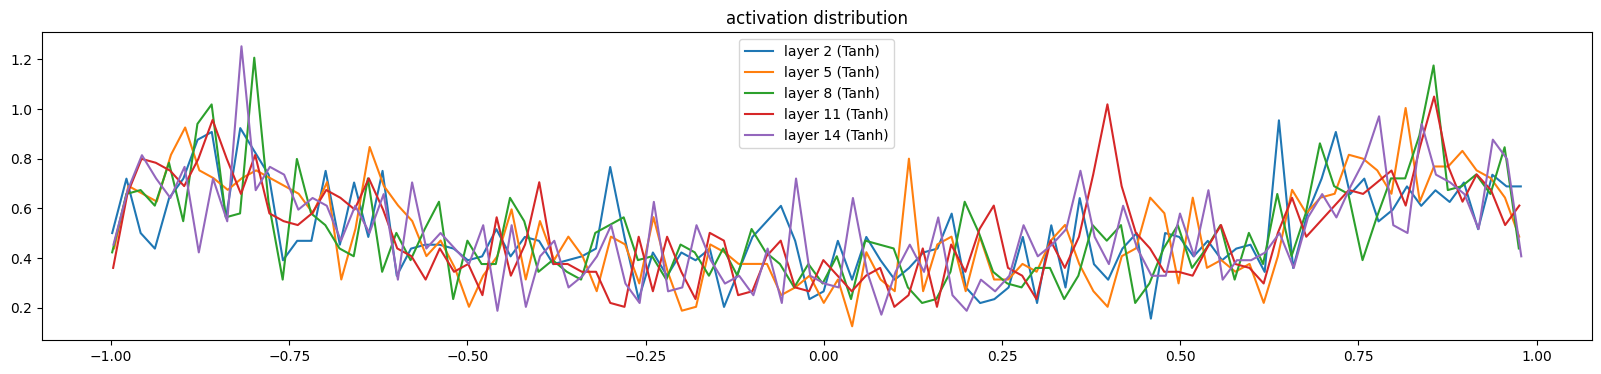

In [16]:
# visualize histograms
plt.figure(figsize=(20 , 4)) # width and height of the plot
legends = []
for i , layer in enumerate(layers[:-1]): # note: exclude the output layer
    if isinstance(layer , Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+.2f , std %.2f , saturated: %.2f%%' % (i , layer.__class__.__name__ , t.mean() , t.std() , (t.abs() > 0.97).float().mean()*100))
        hy , hx = torch.histogram(t , density=True)
        plt.plot(hx[:-1].detach() , hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('activation distribution')

layer 2 (      Tanh): mean +0.00 , std 0.00 , saturated: 0.00%
layer 5 (      Tanh): mean +0.00 , std 0.00 , saturated: 0.00%
layer 8 (      Tanh): mean +0.00 , std 0.00 , saturated: 0.00%
layer 11 (      Tanh): mean -0.00 , std 0.00 , saturated: 0.00%
layer 14 (      Tanh): mean -0.00 , std 0.00 , saturated: 0.00%


Text(0.5, 1.0, 'activation distribution')

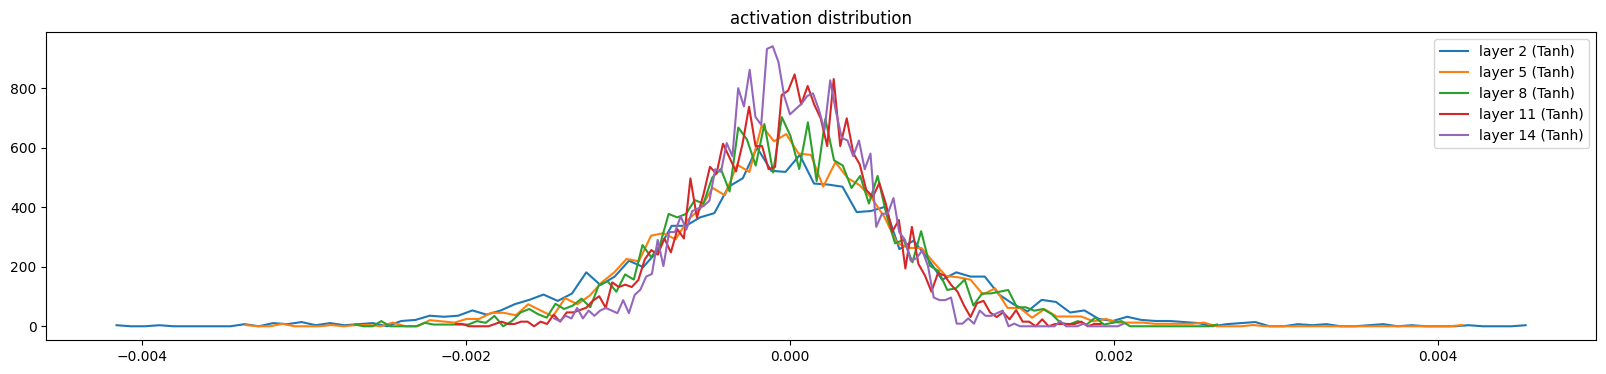

In [17]:
# visualize histograms
plt.figure(figsize=(20 , 4)) # width and height of the plot
legends = []
for i , layer in enumerate(layers[:-1]): # note: exclude the output layer
    if isinstance(layer , Tanh):
        t = layer.out.grad
        print('layer %d (%10s): mean %+.2f , std %.2f , saturated: %.2f%%' % (i , layer.__class__.__name__ , t.mean() , t.std() , (t.abs() > 0.97).float().mean()*100))
        hy , hx = torch.histogram(t , density=True)
        plt.plot(hx[:-1].detach() , hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('activation distribution')